In [2]:
import os
import sys

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))

from pytorch_lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.strategies import DDPStrategy
from time import perf_counter
import wandb
import numpy as np

from src.algorithms.unrolling_policy_iteration import UnrollingPolicyIterationTrain
from src.environments import CliffWalkingEnv, MirroredCliffWalkingEnv
from src.algorithms.generalized_policy_iteration import PolicyIterationTrain
from src.utils import get_optimal_q, test_pol_err, plot_errors, save_error_matrix_to_csv

SAVE = True
PATH = "results/transfer/"

## Auxiliary functions

In [ ]:
def run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger=True, log_every_n_steps=1, verbose=False):
    err = np.zeros((len(Exps), N_unrolls.size))
    err_tranf = np.zeros((len(Exps), N_unrolls.size))
    bell_err_tranf = np.zeros((len(Exps), N_unrolls.size))
    
    use_logger = use_logger and g == 0

    for i, n_unrolls in enumerate(N_unrolls):
        n_unrolls = int(n_unrolls)
        for j, exp in enumerate(Exps):
            env = CliffWalkingEnv()
            env_test = MirroredCliffWalkingEnv()
            if exp["model"] == "unroll":
                model = UnrollingPolicyIterationTrain(env=env, env_test=env_test, num_unrolls=n_unrolls, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}unrolls",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=3000, log_every_n_steps=log_every_n_steps, accelerator="cpu", logger=logger)

                trainer.fit(model)
                wandb.finish()

                _, err[j,i] = test_pol_err(model.Pi, q_opt, mirror_env=False, device=model.device)
                _, err_tranf[j,i] = test_pol_err(model.Pi_test, q_opt_mirr, mirror_env=True, device=model.device)
                bell_err_tranf[j,i] = model.bellman_error_test.cpu().numpy()

            elif exp["model"] == "pol-it":
                model = PolicyIterationTrain(env=env_test, goal_row=0, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}impr",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=n_unrolls, log_every_n_steps=log_every_n_steps, accelerator='cpu', logger=logger)

                trainer.fit(model)
                wandb.finish()

                _, err[j,i] = test_pol_err(model.Pi, q_opt_mirr, mirror_env=True, device=model.device)
                err_tranf[j,i] = err[j,i]
                bell_err_tranf[j,i] = model.bellman_error.cpu().numpy()
                
            else:
                raise Exception("Unknown model")

            if verbose:
                print(f"- {g}. Unrolls {n_unrolls}: Model: {exp["name"]} Err: {err[j,i]:.3f} | Err tranf: {err_tranf[j,i]:.3f} | bell_err: {bell_err_tranf[j,i]:.3f}")
    return err, err_tranf, bell_err_tranf


## K = 3

In [ ]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 3
group_name = f"transfer-K{K}"

N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    # {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(mirror_env=False, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)
q_opt_mirr = get_optimal_q(mirror_env=True, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
wandb: Currently logged in as: samuel-rey (samuel-rey-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=7z6b, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]             

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 179.93it/s, v_num=7z6b, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 111.94it/s, v_num=7z6b, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
policy_diff,█▆▅▅▅▄▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
bellman_error,0
epoch,49
policy_diff,0
q_norm,708.56281
trainer/global_step,49


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 203.03it/s, v_num=gwpa, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 126.29it/s, v_num=gwpa, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
policy_diff,█▇▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
bellman_error,0
epoch,49
policy_diff,0
q_norm,1076.57019
trainer/global_step,49


In [ ]:
n_runs = 5

errs = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs_trans = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs[g], errs_trans[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs=errs, errs_trans=errs_trans, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 229.51it/s, v_num=1hxh, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 138.10it/s, v_num=1hxh, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁█
epoch,▁█
policy_diff,█▁
q_norm,▁█
trainer/global_step,▁██
bellman_error,0.48132
epoch,1
policy_diff,4.47214
q_norm,962.44452
trainer/global_step,1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.01it/s, v_num=ubf9, bellman_error=0.000612, policy_diff=5.100, q_norm=2.15e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.00it/s, v_num=ubf9, bellman_error=0.000612, policy_diff=5.100, q_norm=2.15e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,█▁
q_norm,█▁
trainer/global_step,▁██
bellman_error,0.00061
epoch,1
policy_diff,5.09902
q_norm,2151.66455
trainer/global_step,1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: pol-it-10eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.001


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 165.25it/s, v_num=8d3i, reward_smoothness=0.980, bellman_error=15.00, loss=1.170]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 94.76it/s, v_num=8d3i, reward_smoothness=0.980, bellman_error=15.00, loss=1.170] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▇▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
loss,█▆▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_smoothness,▇▇▅▇▅▇▅▅▂▅▇▇▅▂▅▂▁▁▅▂▅▇▅▅▅▇▅▅▅▅▇▅▅▂▅▅▅▅▅█
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
bellman_error,14.97458
epoch,2999
loss,1.16791
reward_smoothness,0.97973
trainer/global_step,2999


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: unr-K10-WS Err: 0.344 | Err tranf: 0.294 | bell_err: 0.416


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 197.53it/s, v_num=3ymg, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 118.24it/s, v_num=3ymg, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▆█▁▁
epoch,▁▃▆█
policy_diff,█▆▁▁
q_norm,▁▆▇█
trainer/global_step,▁▃▆██
bellman_error,0.01249
epoch,3
policy_diff,0
q_norm,981.5705
trainer/global_step,3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 182.17it/s, v_num=lm2f, bellman_error=0.000401, policy_diff=2.000, q_norm=1.66e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 110.69it/s, v_num=lm2f, bellman_error=0.000401, policy_diff=2.000, q_norm=1.66e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁
epoch,▁▃▆█
policy_diff,█▆▂▁
q_norm,█▄▃▁
trainer/global_step,▁▃▆██
bellman_error,0.0004
epoch,3
policy_diff,2
q_norm,1660.27966
trainer/global_step,3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 103.93it/s, v_num=o008, reward_smoothness=0.980, bellman_error=9.980, loss=0.519]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 68.43it/s, v_num=o008, reward_smoothness=0.980, bellman_error=9.980, loss=0.519] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_smoothness,▁███████████████████████████████████████
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
bellman_error,9.98185
epoch,2999
loss,0.51894
reward_smoothness,0.97973
trainer/global_step,2999


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: unr-K10-WS Err: 0.000 | Err tranf: 0.853 | bell_err: 0.550


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 191.71it/s, v_num=pjh8, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 115.81it/s, v_num=pjh8, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▆█▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,█▆▁▁▁▁
q_norm,▁▅▆▇▇█
trainer/global_step,▁▂▄▅▇██
bellman_error,0.01149
epoch,5
policy_diff,0
q_norm,1000.45868
trainer/global_step,5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 190.46it/s, v_num=my1v, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 115.25it/s, v_num=my1v, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,█▇▄▃▁▁
q_norm,█▅▅▃▁▁
trainer/global_step,▁▂▄▅▇██
bellman_error,0
epoch,5
policy_diff,0
q_norm,1076.57019
trainer/global_step,5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 78.98it/s, v_num=jygb, reward_smoothness=0.980, bellman_error=16.70, loss=1.450]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 56.00it/s, v_num=jygb, reward_smoothness=0.980, bellman_error=16.70, loss=1.450]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▆▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_smoothness,▁▆▆█▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▆▇▆▇▇▇
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
bellman_error,16.71205
epoch,2999
loss,1.45465
reward_smoothness,0.97973
trainer/global_step,2999


- 0. Unrolls 6: Model: unr-K10-WS Err: 0.000 | Err tranf: 0.000 | bell_err: 0.015
----- Solved in 2.351 minutes -----


In [ ]:
# # Load data
# data = np.load(PATH + "transfer-K5_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs = data["errs"]
# errs_trans = data["errs_trans"]
# bell_errs = data["bell_errs"]

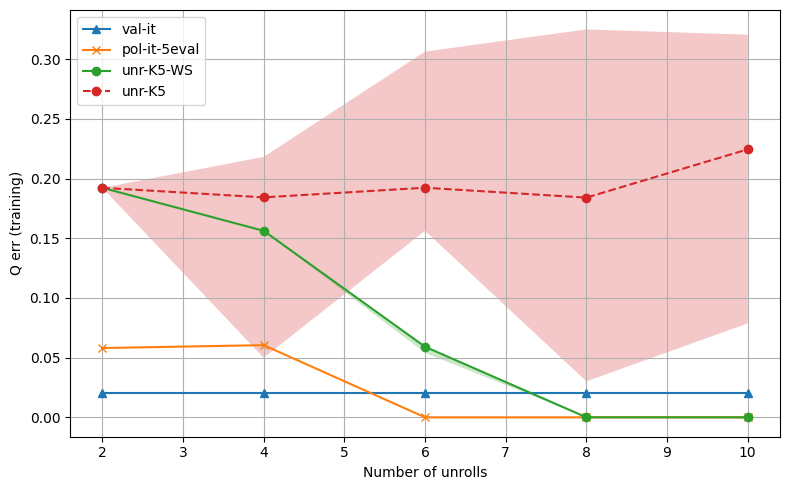

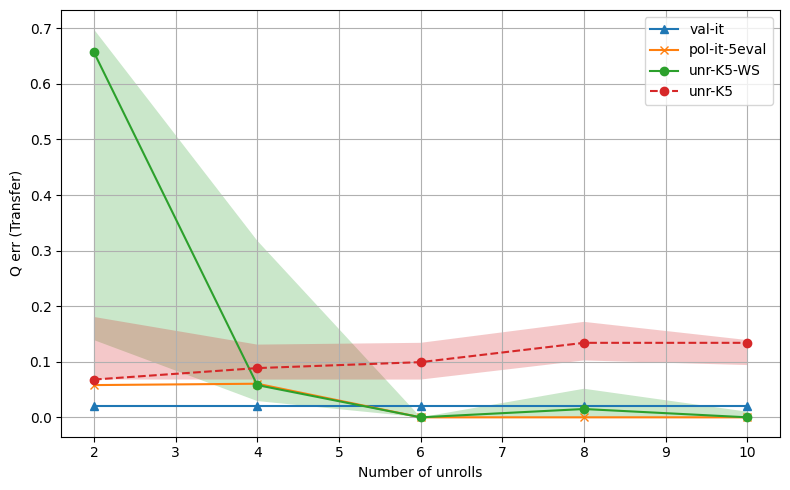

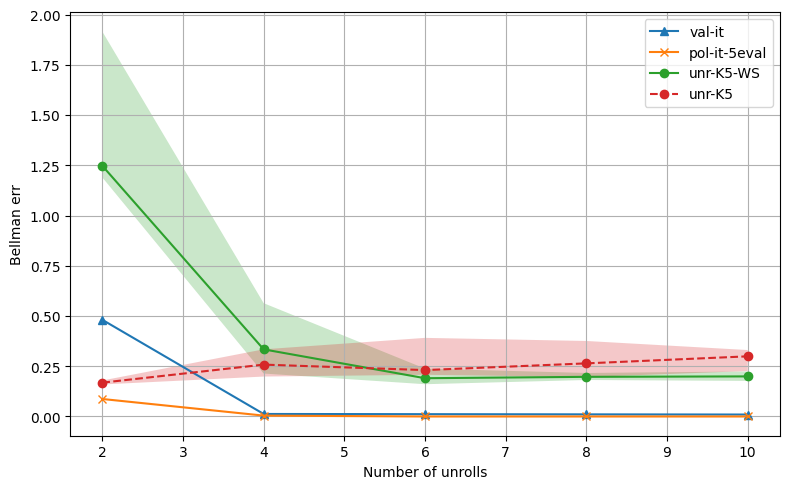

In [ ]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs, N_unrolls, Exps, xlabel, "Q err (training)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q err (Transfer)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K = 5

In [ ]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 5
group_name = f"transfer-K{K}"

N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    # {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(mirror_env=False, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)
q_opt_mirr = get_optimal_q(mirror_env=True, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
wandb: Currently logged in as: samuel-rey (samuel-rey-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=7z6b, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]             

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 179.93it/s, v_num=7z6b, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 111.94it/s, v_num=7z6b, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
policy_diff,█▆▅▅▅▄▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
bellman_error,0
epoch,49
policy_diff,0
q_norm,708.56281
trainer/global_step,49


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 203.03it/s, v_num=gwpa, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 126.29it/s, v_num=gwpa, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▄▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
policy_diff,█▇▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
bellman_error,0
epoch,49
policy_diff,0
q_norm,1076.57019
trainer/global_step,49


In [ ]:
n_runs = 5

errs = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs_trans = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs[g], errs_trans[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs=errs, errs_trans=errs_trans, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 229.51it/s, v_num=1hxh, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 138.10it/s, v_num=1hxh, bellman_error=0.481, policy_diff=4.470, q_norm=962.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▁█
epoch,▁█
policy_diff,█▁
q_norm,▁█
trainer/global_step,▁██
bellman_error,0.48132
epoch,1
policy_diff,4.47214
q_norm,962.44452
trainer/global_step,1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.481


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.01it/s, v_num=ubf9, bellman_error=0.000612, policy_diff=5.100, q_norm=2.15e+3]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.00it/s, v_num=ubf9, bellman_error=0.000612, policy_diff=5.100, q_norm=2.15e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,█▁
q_norm,█▁
trainer/global_step,▁██
bellman_error,0.00061
epoch,1
policy_diff,5.09902
q_norm,2151.66455
trainer/global_step,1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: pol-it-10eval Err: 0.020 | Err tranf: 0.020 | bell_err: 0.001


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 165.25it/s, v_num=8d3i, reward_smoothness=0.980, bellman_error=15.00, loss=1.170]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 94.76it/s, v_num=8d3i, reward_smoothness=0.980, bellman_error=15.00, loss=1.170] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▇▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
loss,█▆▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_smoothness,▇▇▅▇▅▇▅▅▂▅▇▇▅▂▅▂▁▁▅▂▅▇▅▅▅▇▅▅▅▅▇▅▅▂▅▅▅▅▅█
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
bellman_error,14.97458
epoch,2999
loss,1.16791
reward_smoothness,0.97973
trainer/global_step,2999


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: unr-K10-WS Err: 0.344 | Err tranf: 0.294 | bell_err: 0.416


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 197.53it/s, v_num=3ymg, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 118.24it/s, v_num=3ymg, bellman_error=0.0125, policy_diff=0.000, q_norm=982.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▆█▁▁
epoch,▁▃▆█
policy_diff,█▆▁▁
q_norm,▁▆▇█
trainer/global_step,▁▃▆██
bellman_error,0.01249
epoch,3
policy_diff,0
q_norm,981.5705
trainer/global_step,3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.012


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 182.17it/s, v_num=lm2f, bellman_error=0.000401, policy_diff=2.000, q_norm=1.66e+3]

`Trainer.fit` stopped: `max_epochs=4` reached.


Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 110.69it/s, v_num=lm2f, bellman_error=0.000401, policy_diff=2.000, q_norm=1.66e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁
epoch,▁▃▆█
policy_diff,█▆▂▁
q_norm,█▄▃▁
trainer/global_step,▁▃▆██
bellman_error,0.0004
epoch,3
policy_diff,2
q_norm,1660.27966
trainer/global_step,3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 103.93it/s, v_num=o008, reward_smoothness=0.980, bellman_error=9.980, loss=0.519]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 68.43it/s, v_num=o008, reward_smoothness=0.980, bellman_error=9.980, loss=0.519] 
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▆▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_smoothness,▁███████████████████████████████████████
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
bellman_error,9.98185
epoch,2999
loss,0.51894
reward_smoothness,0.97973
trainer/global_step,2999


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 4: Model: unr-K10-WS Err: 0.000 | Err tranf: 0.853 | bell_err: 0.550


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 191.71it/s, v_num=pjh8, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3] 

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 115.81it/s, v_num=pjh8, bellman_error=0.0115, policy_diff=0.000, q_norm=1e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,▆█▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,█▆▁▁▁▁
q_norm,▁▅▆▇▇█
trainer/global_step,▁▂▄▅▇██
bellman_error,0.01149
epoch,5
policy_diff,0
q_norm,1000.45868
trainer/global_step,5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: val-it Err: 0.020 | Err tranf: 0.020 | bell_err: 0.011


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 190.46it/s, v_num=my1v, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]   

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 115.25it/s, v_num=my1v, bellman_error=0.000, policy_diff=0.000, q_norm=1.08e+3]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁▁▁▁▁
epoch,▁▂▄▅▇█
policy_diff,█▇▄▃▁▁
q_norm,█▅▅▃▁▁
trainer/global_step,▁▂▄▅▇██
bellman_error,0
epoch,5
policy_diff,0
q_norm,1076.57019
trainer/global_step,5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 6: Model: pol-it-10eval Err: 0.000 | Err tranf: 0.000 | bell_err: 0.000


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params
0         Non-trainable params
22        Total params
0.000     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 78.98it/s, v_num=jygb, reward_smoothness=0.980, bellman_error=16.70, loss=1.450]

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 2999: 100%|██████████| 1/1 [00:00<00:00, 56.00it/s, v_num=jygb, reward_smoothness=0.980, bellman_error=16.70, loss=1.450]
P_pi is NOT diagonalizable


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▆▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reward_smoothness,▁▆▆█▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▆▇▆▇▇▇
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
bellman_error,16.71205
epoch,2999
loss,1.45465
reward_smoothness,0.97973
trainer/global_step,2999


- 0. Unrolls 6: Model: unr-K10-WS Err: 0.000 | Err tranf: 0.000 | bell_err: 0.015
----- Solved in 2.351 minutes -----


In [ ]:
# # Load data
# data = np.load(PATH + "transfer-K5_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs = data["errs"]
# errs_trans = data["errs_trans"]
# bell_errs = data["bell_errs"]

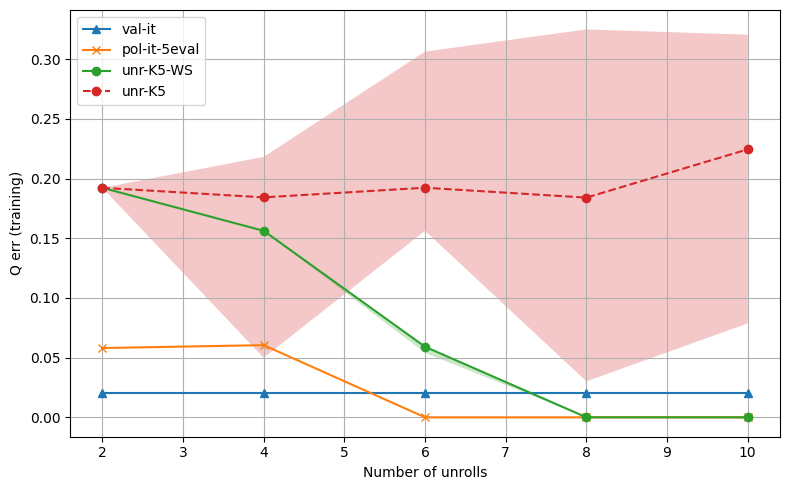

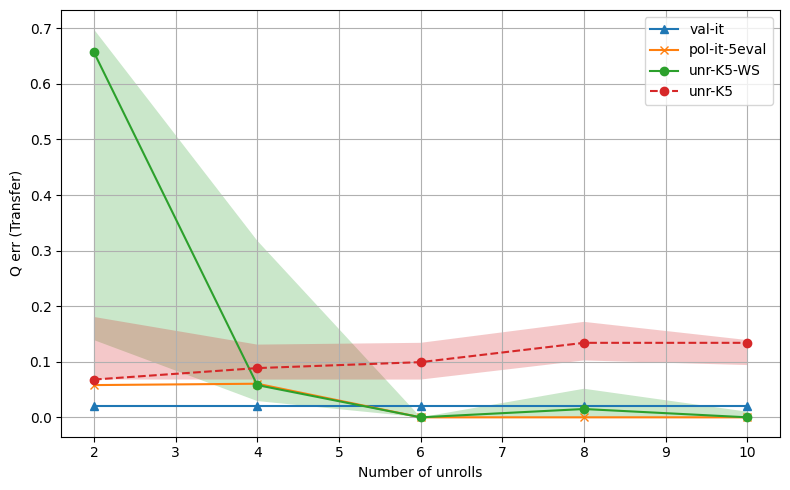

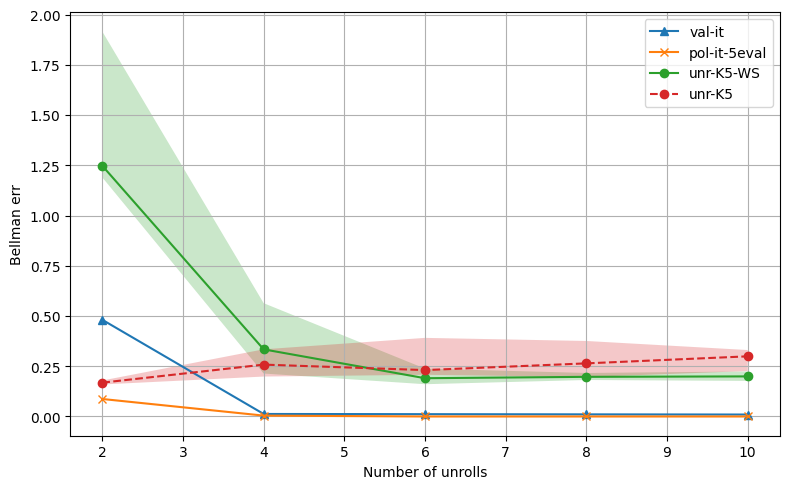

In [4]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs, N_unrolls, Exps, xlabel, "Q err (training)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q err (Transfer)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=10

In [ ]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 10
group_name = f"transfer-K{K}"
N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    # {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(mirror_env=False, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)
q_opt_mirr = get_optimal_q(mirror_env=True, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 5

errs = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs_trans = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs[g], errs_trans[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs=errs, errs_trans=errs_trans, bell_errs=bell_errs)
    print("Data saved as:", file_name)

In [ ]:
# # Load data
# data = np.load(PATH + "transfer-K10_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs = data["errs"]
# errs_trans = data["errs_trans"]
# bell_errs = data["bell_errs"]

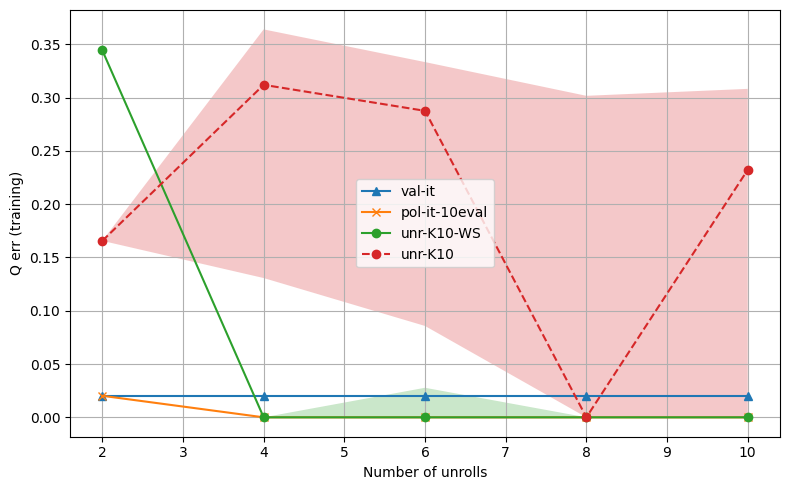

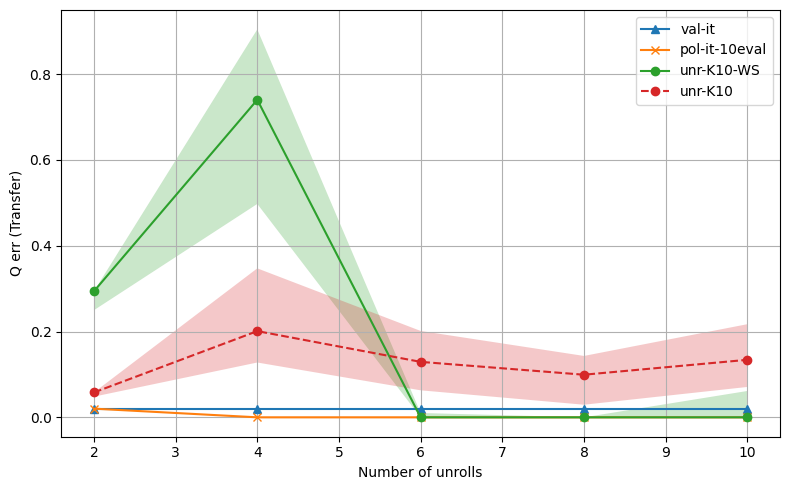

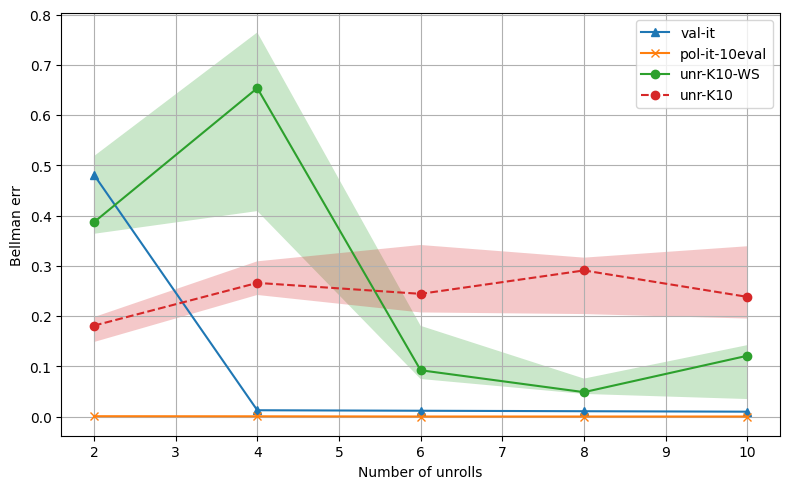

In [9]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs, N_unrolls, Exps, xlabel, "Q err (training)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q err (Transfer)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=15

In [ ]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 15
group_name = f"transfer-K{K}"
N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    # {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(mirror_env=False, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)
q_opt_mirr = get_optimal_q(mirror_env=True, use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 5

errs = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs_trans = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs[g], errs_trans[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, q_opt_mirr, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs=errs, errs_trans=errs_trans, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 234.20it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 196.91it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 195.00it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

- 0. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 2: Model: unr-K5-WS Err1: 1.285 | bell_err: 0.035
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K10-WS Err1: 2.217 | bell_err: 0.017
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.92it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 236.97it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 103.38it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 225.32it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 0. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 5: Model: unr-K5-WS Err1: 0.950 | bell_err: 0.019
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 237.77it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.76it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


- 0. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.013
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.006
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 181.72it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.28it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 183.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.19it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 98.81it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 2: Model: unr-K5-WS Err1: 1.909 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K10-WS Err1: 0.128 | bell_err: 0.016
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.91it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 239.77it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 98.17it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 237.56it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 5: Model: unr-K5-WS Err1: 0.813 | bell_err: 0.016
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 240.09it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 227.77it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.83it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 225.14it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


- 1. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.025
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.56it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 2. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.92it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 2. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1734:   0%|          | 0/1 [00:00<?, ?it/s, reward_smoothness=0.980, bellman_error=14.80, loss=1.150]         

In [ ]:
# # Load data
# data = np.load(PATH + "transfer-K15_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs = data["errs"]
# errs_trans = data["errs_trans"]
# bell_errs = data["bell_errs"]

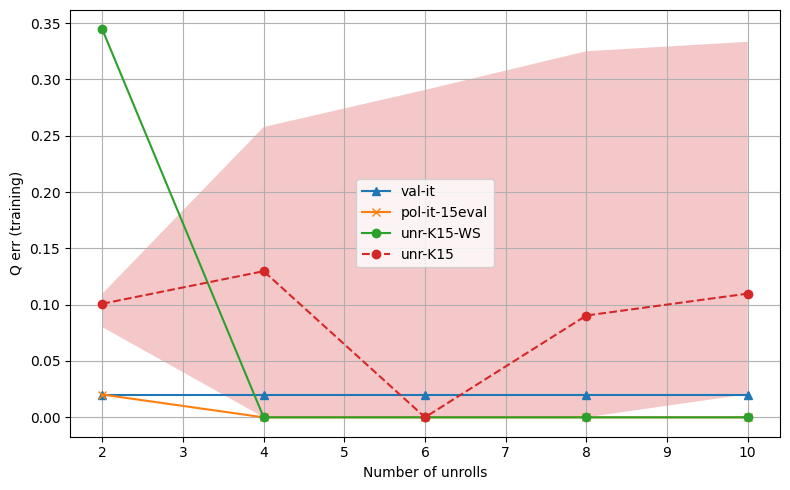

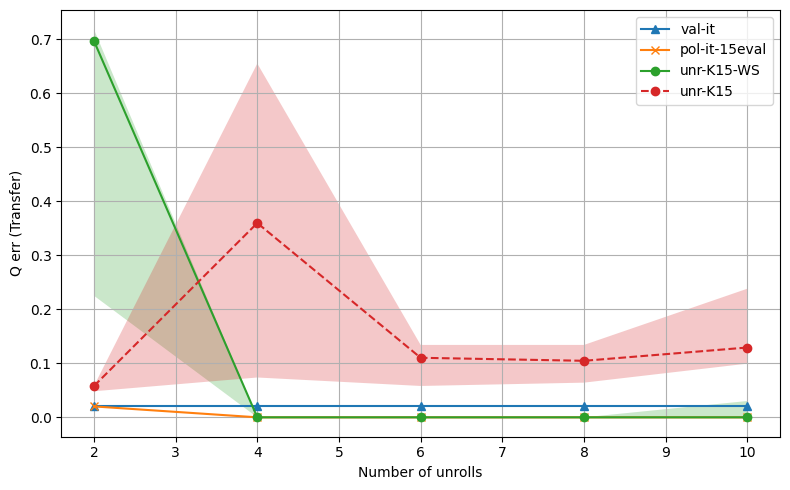

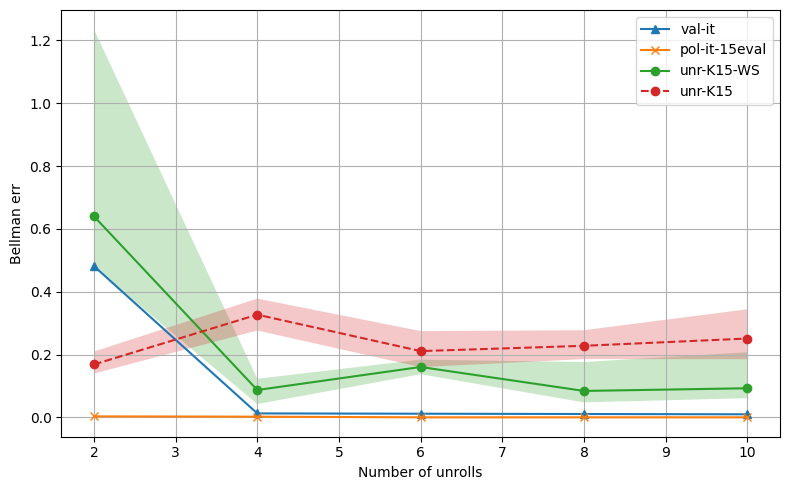

In [12]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs, N_unrolls, Exps, xlabel, "Q err (training)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q err (Transfer)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Plot All

In [4]:
# Load data
files = ["transfer-K5_data.npz", "transfer-K10_data.npz", "transfer-K15_data.npz"]

Exps = []
errs_list = []
errs_trans_list = []
bell_errs_list = []
for file in files:
    data = np.load(PATH + file, allow_pickle=True)
    
    if 'N_unrolls' not in locals():  # Save only once
        N_unrolls = data["N_unrolls"]
    
    Exps += list(data["Exps"])
    
    errs_list.append(data["errs"])
    errs_trans_list.append(data["errs_trans"])
    bell_errs_list.append(data["bell_errs"])

# Concatenate all data
errs = np.concatenate(errs_list, axis=1)
errs_trans = np.concatenate(errs_trans_list, axis=1)
bell_errs = np.concatenate(bell_errs_list, axis=1)

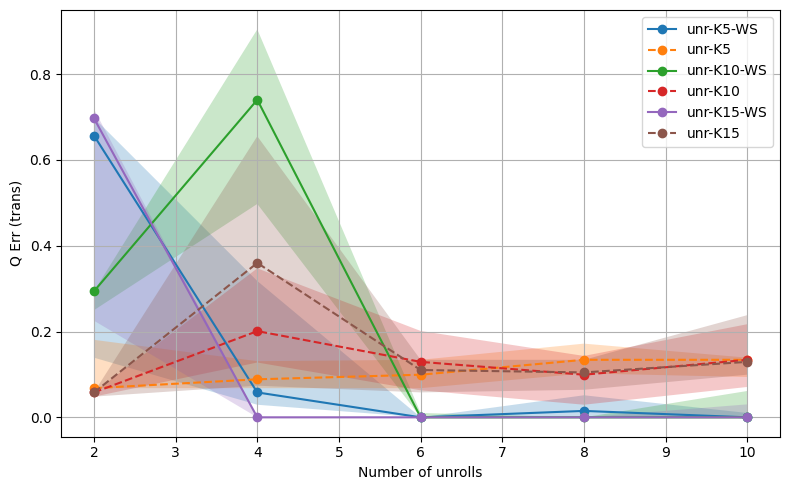

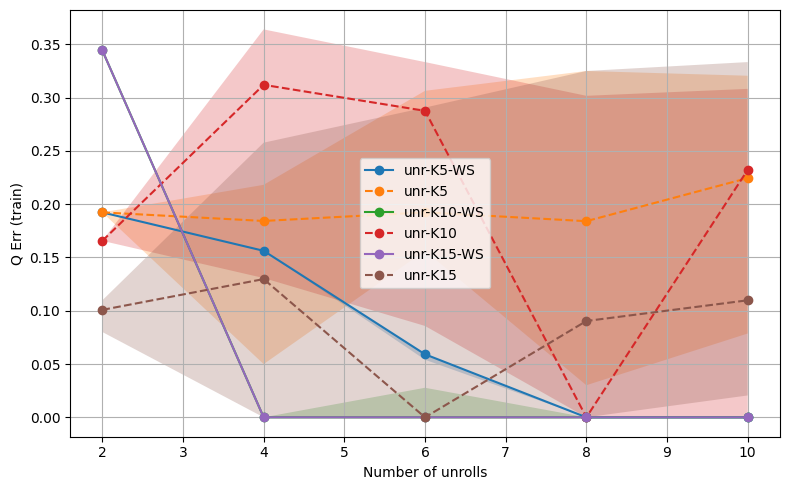

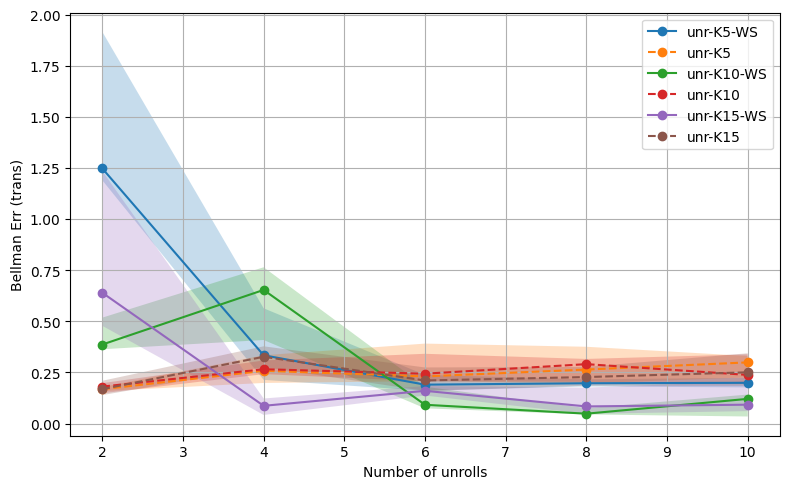

In [5]:
# Indexes 0, 4 and 8 are all policy evaluation
skip_idx = [0, 1, 4, 5, 8, 9]
xlabel = "Number of unrolls"
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q Err (trans)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs, N_unrolls, Exps, xlabel, "Q Err (train)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman Err (trans)", skip_idx=skip_idx, agg="median", deviation='prctile')

if SAVE:
    file_name = PATH + "transfer_all_data_med_err.csv"
    save_error_matrix_to_csv(np.median(errs_trans, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "transfer_all_data_prctile25.csv"
    save_error_matrix_to_csv(np.percentile(errs_trans, 25, axis=0), N_unrolls, Exps, file_name)
    file_name = PATH + "transfer_all_data_prctile75.csv"
    save_error_matrix_to_csv(np.percentile(errs_trans, 75, axis=0), N_unrolls, Exps, file_name)


## Plot All - New Loss Transferability Results

In [9]:
# Configuration
SAVE = True
PATH = "./"

# Load data from single file
file = "new_loss_transferability_data.npz"
data = np.load(PATH + file, allow_pickle=True)

# Extract data
N_unrolls = data["N_unrolls"]
Exps = list(data["Exps"])
errs = data["errs"]
errs_trans = data["errs_trans"] 
bell_errs = data["bell_errs"]

print(f"Loaded data with shape:")
print(f"- N_unrolls: {N_unrolls.shape}")
print(f"- Experiments: {len(Exps)}")
print(f"- errs: {errs.shape}")
print(f"- errs_trans: {errs_trans.shape}")
print(f"- bell_errs: {bell_errs.shape}")

print(f"\nExperiment names:")
for i, exp in enumerate(Exps):
    print(f"{i}: {exp['name']}")

Loaded data with shape:
- N_unrolls: (5,)
- Experiments: 11
- errs: (15, 11, 5)
- errs_trans: (15, 11, 5)
- bell_errs: (15, 11, 5)

Experiment names:
0: val-it
1: pol-it-5eval
2: unr-K5-WS
3: unr-K5-original_with_detach-zeros
4: unr-K5-original_with_detach-random
5: unr-K5-original_no_detach-zeros
6: unr-K5-original_no_detach-random
7: unr-K5-max_with_detach-zeros
8: unr-K5-max_with_detach-random
9: unr-K5-max_no_detach-zeros
10: unr-K5-max_no_detach-random


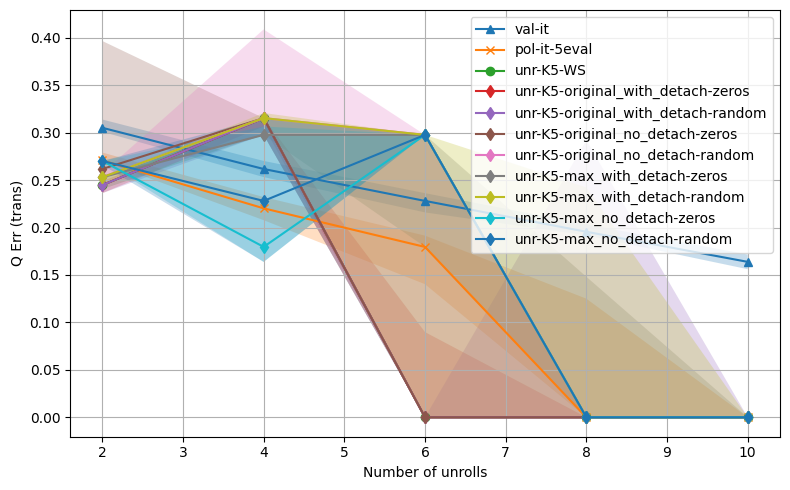

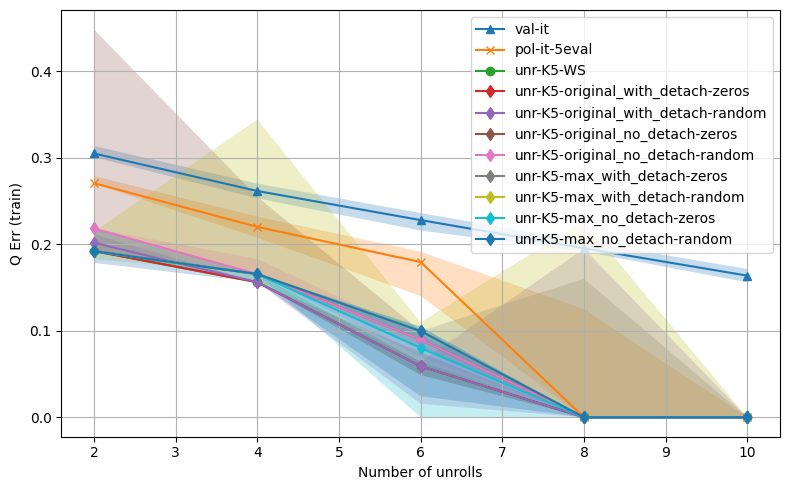

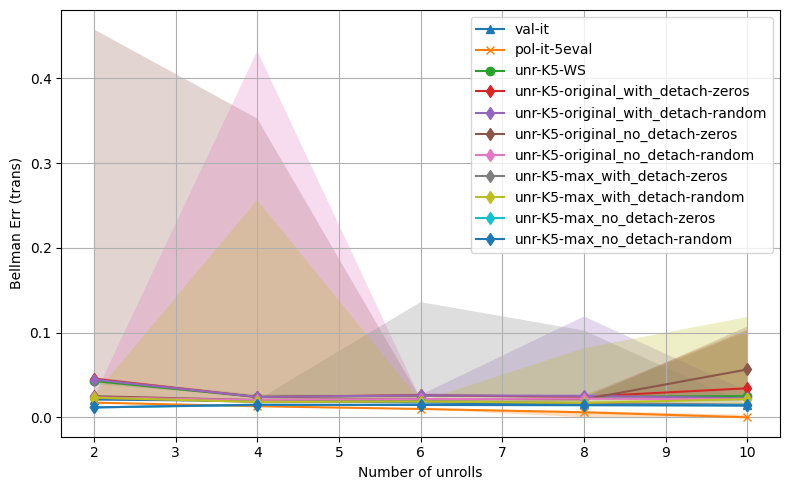

Data saved to csv file: ./new_loss_transferability_med_err.csv
Data saved to csv file: ./new_loss_transferability_prctile25.csv
Data saved to csv file: ./new_loss_transferability_prctile75.csv

=== SUMMARY STATISTICS ===
Best performing experiments (lowest median transfer error at max unrolls):

Ranking at 10 unrolls:
1. unr-K5-original_with_detach-zeros: 0.0000
2. unr-K5-original_with_detach-random: 0.0000
3. pol-it-5eval: 0.2280
4. val-it: 0.2701
5. unr-K5-WS: 0.2976


In [10]:
# Define which experiments to skip in plots
skip_idx = []

# Plot parameters
xlabel = "Number of unrolls"

# Generate plots
plot_errors(errs_trans, N_unrolls, Exps, xlabel, "Q Err (trans)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs, N_unrolls, Exps, xlabel, "Q Err (train)", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman Err (trans)", skip_idx=skip_idx, agg="median", deviation='prctile')

# Save CSV files with results
if SAVE:
    # Median errors
    file_name = PATH + "new_loss_transferability_med_err.csv"
    save_error_matrix_to_csv(np.median(errs_trans, axis=0), N_unrolls, Exps, file_name)
    
    # 25th percentile
    file_name = PATH + "new_loss_transferability_prctile25.csv"
    save_error_matrix_to_csv(np.percentile(errs_trans, 25, axis=0), N_unrolls, Exps, file_name)
    
    # 75th percentile  
    file_name = PATH + "new_loss_transferability_prctile75.csv"
    save_error_matrix_to_csv(np.percentile(errs_trans, 75, axis=0), N_unrolls, Exps, file_name)

# Summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(f"Best performing experiments (lowest median transfer error at max unrolls):")

final_unroll_idx = -1  # Last unroll value
final_errors = np.median(errs_trans[:, final_unroll_idx, :], axis=0)

# Sort by performance
sorted_indices = np.argsort(final_errors)
print(f"\nRanking at {N_unrolls[final_unroll_idx]} unrolls:")
for rank, idx in enumerate(sorted_indices[:5]):  # Top 5
    exp_name = Exps[idx]['name']
    error = final_errors[idx]
    print(f"{rank+1}. {exp_name}: {error:.4f}")